In [93]:
import agentpy as ap

if it bull market condition : 

Total token supply will be 4%, 2% goes to validator incentives and 2% goes to community treasury 
also the transaction rate will be very high and transaction fee will be high 
validator_incentives will be high 
it will be high adoption levels


if it bear market condition : 

Total token supply will be 0.2%, 0.1% goes to validator incentives and 0.1% goes to community treasury 
also the transaction rate will be very low and transaction fee will be low 
validator_incentives will be low
it will be low adoption levels

if it Base market condition : 

Total token supply will be 2%, 1% goes to validator incentives and 1% goes to community treasury 
also the transaction rate will be medium and transaction fee will be medium 
validator_incentives will be low
it will be medium adoption levels

In [86]:
class Staker(ap.Agent):
    def setup(self, initial_supply, staking_provision):
        self.holding = initial_supply * 0.35
        self.staking_provision = 0.35
        self.staking_rewards = 0  # To track staking rewards
        self.unstaked_amount = 0  # To track unstaking amounts
        self.staked_amount = 0  # To track staked amounts

    def stake(self, amount):
        self.holding += amount
        self.staked_amount += amount
        self.staking_rewards += amount * self.staking_provision

    def unstake(self, amount):
        if self.holding >= amount:
            self.holding -= amount
            self.unstaked_amount += amount
            return amount
        return 0


class Validator(ap.Agent):
    def setup(self):
        self.operational_cost = 10000
        self.performance = 1.0
        self.validator_incentives = 0.02 

    def validate(self):
        # Placeholder validation logic
        return self.performance

In [94]:
class OHM(ap.Model):
    def setup(self):
        # Initialize an attribute with parameter requirements
        self.initial_supply = 21e9
        self.yearly_emissions = 0.04  # 4% for the first decade
        self.validator_incentives = 0.02
        self.community_treasury = 0.02
        self.num_validators_L1 = 100
        self.num_validators_middleware = 20
        self.operational_cost_per_validator = 10000
        self.staking_provision = 0.35
        self.incentivization_scenarios = ['scenario1', 'scenario2', 'scenario3']
        self.adoption_scenarios = ['low', 'medium', 'high']
        self.current_step = 0

        # Model components
        self.stakers = ap.AgentList(self, 100, Staker, initial_supply=self.initial_supply, staking_provision=self.staking_provision)
        self.validators_L1 = ap.AgentList(self, self.num_validators_L1, Validator)
        self.validators_middleware = ap.AgentList(self, self.num_validators_middleware, Validator)
        self.treasury = 0
        self.total_supply = self.initial_supply * (1 + self.yearly_emissions)  # Initialize total_supply


    def adjust_parameters(self, agent, scenario):
        # Common adjustments for all agents
        if scenario == 'bull':
            agent.validator_incentives *= 1.2
            agent.operational_cost *= 0.9
        elif scenario == 'bear':
            agent.validator_incentives *= 0.8
            agent.operational_cost *= 1.2
            agent.performance *= 0.9

    def staker_behaviors(self):
        # Staker behaviors
        for staker in self.stakers:
            staking_amount = staker.holding * self.staking_provision
            staker.stake(staking_amount)

            if self.p.economic_outlook_scenarios == 'bull':
                # Adjust parameters for bull market
                staking_reward_increase_percentage = 0.2
                additional_rewards = staker.holding * self.staking_provision * staking_reward_increase_percentage
                staker.stake(additional_rewards)
                staker.staking_provision *= 1.1  # Increase staking rewards

            if self.p.economic_outlook_scenarios == 'bear':
                staker.staking_provision *= 0.8  # Decrease staking rewards
                staker.unstake(0.1 * staker.holding)  # Unstake 10% of holding


    def validator_behaviors(self, validators):
        for validator in validators:
            validation_reward = validator.validate() * self.validator_incentives
            self.treasury += validation_reward
            validator.operational_cost += self.operational_cost_per_validator
            self.adjust_parameters(validator, self.p.economic_outlook_scenarios)

    

    def step(self):
        print(f"\n Current economic outlook scenarios: {self.p.economic_outlook_scenarios}")

        if self.p.economic_outlook_scenarios == 'bull':
            print('bull')
            self.validator_incentives *= 1.2
            self.community_treasury += 0.02 * self.total_supply
            self.operational_cost_per_validator *= 0.9
            self.transaction_rate_L1 = 0.2
            self.transaction_rate_middleware = 0.1
            self.transaction_fee_L1 = 0.02
            self.transaction_fee_middleware = 0.01
            self.adoption_level = 'high'
            
            self.staker_behaviors()
            self.validator_behaviors(self.validators_L1)
            self.validator_behaviors(self.validators_middleware)

        elif self.p.economic_outlook_scenarios == 'bear':
            print('bear')
            self.validator_incentives *= 0.8
            self.community_treasury += 0.001 * self.total_supply
            self.transaction_rate_L1 = 0.05
            self.transaction_rate_middleware = 0.02
            self.transaction_fee_L1 = 0.005
            self.transaction_fee_middleware = 0.002
            self.adoption_level = 'low'

            self.staker_behaviors()
            self.validator_behaviors(self.validators_L1)
            self.validator_behaviors(self.validators_middleware)

        else:  # Base market condition
            print('base')
            self.validator_incentives *= 0.9
            self.community_treasury += 0.01 * self.total_supply
            self.transaction_rate_L1 = 0.1
            self.transaction_rate_middleware = 0.05
            self.transaction_fee_L1 = 0.01
            self.transaction_fee_middleware = 0.005
            self.adoption_level = 'medium'

            self.staker_behaviors()
            self.validator_behaviors(self.validators_L1)
            self.validator_behaviors(self.validators_middleware)

        yearly_emission = self.total_supply * self.yearly_emissions
        self.total_supply += min(yearly_emission, 0.04 * self.total_supply)

        self.current_step += 1

    def update(self):

        staking_total = sum(staker.holding * self.staking_provision for staker in self.stakers)
        unstaking_total = sum(staker.unstake(0.1 * staker.holding) for staker in self.stakers)  # Assuming 10% unstaking
        stakers_net_supply = staking_total - unstaking_total

        print(f"Stakers total supply: {stakers_net_supply}")
        self.record('Stakers_Net_Supply', stakers_net_supply)


        # Update staking rewards
        total_staking_rewards = sum(staker.staking_rewards for staker in self.stakers)
        self.record('Total_Staking_Rewards', total_staking_rewards)

        # Update unstaking amounts
        total_unstaking_amount = sum(staker.unstaked_amount for staker in self.stakers)
        self.record('Total_Unstaking_Amount', total_unstaking_amount)

        # Calculate and record staking yield
        staking_yield = (total_staking_rewards / staking_total) * 100
        self.record('Staking_Yield', staking_yield)

        # Update staking provisions
        total_staked_amount = sum(staker.staked_amount for staker in self.stakers)
        self.record('Total_Staked_Amount', total_staked_amount)

        validators_total_supply_L1 = sum(validator.operational_cost for validator in self.validators_L1)
        validators_total_supply_middleware = sum(validator.operational_cost for validator in self.validators_middleware)
        print(f"Validators (L1) total supply: {validators_total_supply_L1}")
        self.record('Validators_L1_Total_Supply', validators_total_supply_L1)
        print(f"Validators (Middleware) total supply: {validators_total_supply_middleware}")
        self.record('Validators_Middleware_Total_Supply', validators_total_supply_middleware)

        print(f"Total supply at step {self.current_step}: {self.total_supply}")
        self.record('Total_Supply', self.total_supply)

    

In [97]:
# Create and run the model for 10 years with bull market
simulation_duration = 10
market_condition = 'bear'  # Change this to 'bear' for bear market

parameters = {
    'economic_outlook_scenarios': market_condition,
    'steps': simulation_duration
}

model = OHM(parameters)
results = model.run()

Stakers total supply: 183750000000.0
Validators (L1) total supply: 1000000
Validators (Middleware) total supply: 200000
Total supply at step 0: 21840000000.0

 Current economic outlook scenarios: bear
bear
Stakers total supply: 200930625000.0
Validators (L1) total supply: 2400000.0
Validators (Middleware) total supply: 480000.0
Total supply at step 1: 22713600000.0
Completed: 1 steps
 Current economic outlook scenarios: bear
bear
Stakers total supply: 219717638437.5
Validators (L1) total supply: 4080000.0
Validators (Middleware) total supply: 816000.0
Total supply at step 2: 23622144000.0
Completed: 2 steps
 Current economic outlook scenarios: bear
bear
Stakers total supply: 240261237631.40613
Validators (L1) total supply: 6096000.0
Validators (Middleware) total supply: 1219200.0
Total supply at step 3: 24567029760.0
Completed: 3 steps
 Current economic outlook scenarios: bear
bear
Stakers total supply: 262725663349.94226
Validators (L1) total supply: 8515200.0
Validators (Middleware) 

In [98]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 2 keys
'variables': 
    'OHM': DataFrame with 8 variables and 11 rows
'reporters': DataFrame with 1 variable and 1 row
}

In [99]:
results.info

{'model_type': 'OHM',
 'time_stamp': '2024-02-02 22:55:03',
 'agentpy_version': '0.1.5',
 'python_version': '3.9.6',
 'experiment': False,
 'completed': True,
 'created_objects': 220,
 'completed_steps': 10,
 'run_time': '0:00:00.020155'}

In [100]:
results.variables.OHM.head()

,Stakers_Net_Supply,Total_Staking_Rewards,Total_Unstaking_Amount,Staking_Yield,Total_Staked_Amount,Validators_L1_Total_Supply,Validators_Middleware_Total_Supply,Total_Supply
t,,,,,,,,
0,1.837500e+11,0.000000e+00,7.350000e+10,0.000000,0.000000e+00,1000000.0,200000.0,2.184000e+10
1,2.009306e+11,8.103375e+10,2.431748e+11,28.806584,2.315250e+11,2400000.0,480000.0,2.271360e+10
2,2.197176e+11,1.519221e+11,4.287141e+11,49.388737,4.846976e+11,4080000.0,816000.0,2.362214e+10
3,2.402612e+11,2.139352e+11,6.316014e+11,63.601955,7.615418e+11,6096000.0,1219200.0,2.456703e+10
4,2.627257e+11,2.681842e+11,8.534586e+11,72.912624,1.064271e+12,8515200.0,1703040.0,2.554971e+10


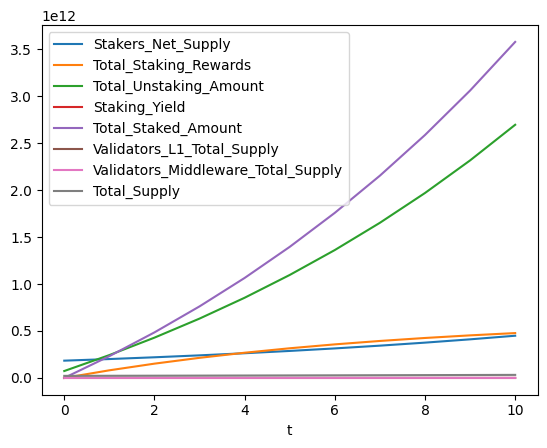

In [101]:
data = results.variables.OHM
ax = data.plot()